In [1]:
# Bayesian inference
# https://www.ritchievink.com/blog/2019/06/10/bayesian-inference-how-we-are-able-to-chase-the-posterior/

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats



$$P(\theta|D) = \frac{P(D|\theta) P(\theta)}{P(D)}$$

In [2]:
# we have observed two data points; D={195,182}  
# Both are observed lengths in cm of men in a basketball competition.
lengths = np.array([195, 182])

# Likelihood function
#  Gaussian distribution of the true weights (the posterior) os assumed

$$ P(D|\theta) = P(D| \mu, \sigma)$$


In [3]:
# lets create a grid of our two parameters
mu = np.linspace(150, 240)
sigma = np.linspace(3, 15)[::-1]

mm, ss = np.meshgrid(mu, sigma)  # just broadcasted parameters

Text(0, 0.5, '$\\sigma$')

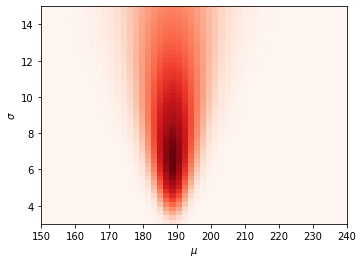

In [4]:
# likelihood

likelihood = stats.norm(mm, ss).pdf(lengths[0]) * stats.norm(mm, ss).pdf(lengths[1])
aspect = mm.max() / ss.max() / 3
extent = [mm.min(), mm.max(), ss.min(), ss.max()]
# extent = left right bottom top

plt.imshow(likelihood, cmap='Reds', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

Likelihood function results: $\mu = 190$, $\sigma =5$

Ny belief: $\mu \sim \mathcal{N}(200, 15^2)$ $\sigma \sim \mathcal{Cauchy}(0, 10^2)
$

Text(0, 0.5, '$\\sigma$')

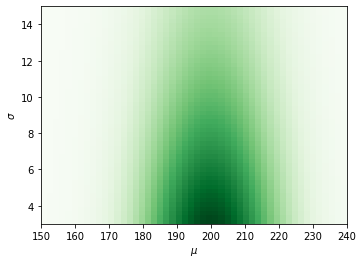

In [5]:
# Prior Distribution

prior = stats.norm(200, 15).pdf(mm) * stats.cauchy(0, 10).pdf(ss)

plt.imshow(prior, cmap='Greens', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

Text(0, 0.5, '$\\sigma$')

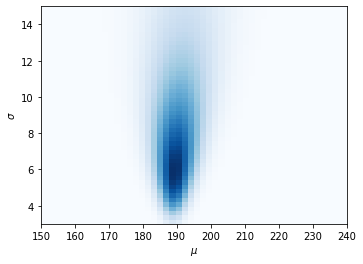

In [6]:
# compute the posterior directly by applying Bayes' rule

unnormalized_posterior = prior * likelihood
posterior = unnormalized_posterior / np.nan_to_num(unnormalized_posterior).sum()
plt.imshow(posterior, cmap='Blues', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

This was easy. Because we weren’t cursed by high dimensions. Increase the dimensions, or define a more complex model, and the calculation of $P(D)$ becomes intractable.

Text(0, 0.5, '$\\sigma$')

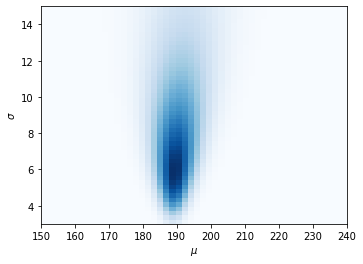

In [7]:
# Markov Chain Monte Carlo (MCMC)

plt.imshow(unnormalized_posterior, cmap='Blues', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

In [8]:
# One tool to tackle this intractability problem is Markov Chain Monte Carlo

# modeling our example in PyMC3.
import pymc3 as pm


with pm.Model():
    # priors
    mu = pm.Normal('mu', mu=200, sd=15)
    sigma = pm.HalfCauchy('sigma', 10)
    
    # likelihood
    observed = pm.Normal('observed', mu=mu, sd=sigma, observed=lengths)
    # sample
    trace = pm.sample(draws=10000, chains=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  from ipykernel import kernelapp as app
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 17 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


(0.0, 15.0)

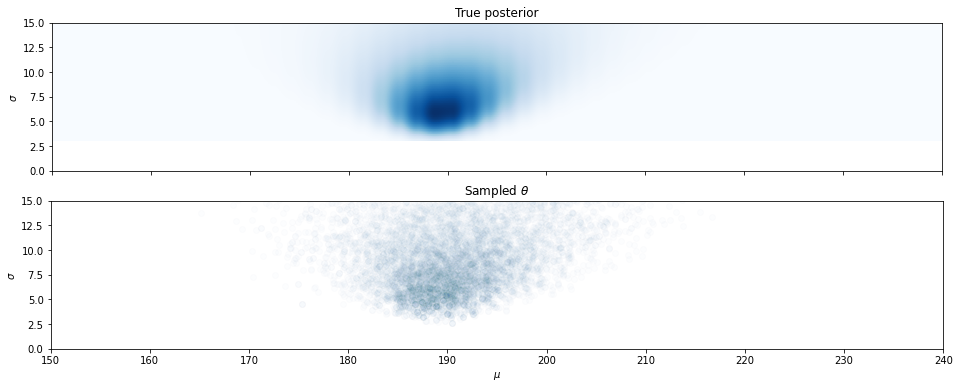

In [9]:
fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize = (16, 6))
axes[0].imshow(posterior, cmap='Blues', extent=extent, aspect=1)
axes[0].set_ylabel('$\sigma$')
axes[1].scatter(trace['mu'], trace['sigma'], alpha=0.01)
axes[1].set_ylabel('$\sigma$')
axes[0].set_title('True posterior')
axes[1].set_title('Sampled $\\theta$')
plt.xlabel('$\mu$')
plt.xlim(150, mm.max())
plt.ylim(0, ss.max())

In [10]:
# Variational Inference in Pyro
!pip install Pyro-ppl

import pyro
import pyro.optim
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import torch
import torch.distributions.constraints as constraints


def model():
    # priors
    mu = pyro.sample('mu', dist.Normal(loc=torch.tensor(200.), 
                                       scale=torch.tensor(15.)))
    sigma = pyro.sample('sigma', dist.HalfCauchy(scale=torch.tensor(10.)))
    
    # likelihood
    with pyro.plate('plate', size=2):
        pyro.sample(f'obs', dist.Normal(loc=mu, scale=sigma), 
                    obs=torch.tensor([195., 185.]))

In [11]:
def guide():
    # variational parameters
    var_mu = pyro.param('var_mu', torch.tensor(180.))
    var_mu_sig = pyro.param('var_mu_sig', torch.tensor(5.),
                             constraint=constraints.positive)
    var_sig = pyro.param('var_sig', torch.tensor(5.))

    # factorized distribution
    pyro.sample('mu', dist.Normal(loc=var_mu, scale=var_mu_sig))
    pyro.sample('sigma', dist.Chi2(var_sig))

In [12]:
pyro.clear_param_store()
pyro.enable_validation(True)

svi = SVI(model, guide, 
          optim=pyro.optim.ClippedAdam({"lr":0.01}), 
          loss=Trace_ELBO())

# do gradient steps
c = 0
for step in range(5000):
    c += 1
    loss = svi.step()
    if step % 100 == 0:
        print("[iteration {:>4}] loss: {:.4f}".format(c, loss))

[iteration    1] loss: 15.2066
[iteration  101] loss: 9.6489
[iteration  201] loss: 7.4239
[iteration  301] loss: 10.3024
[iteration  401] loss: 12.2540
[iteration  501] loss: 9.4606
[iteration  601] loss: 8.1931
[iteration  701] loss: 6.0793
[iteration  801] loss: 9.5090
[iteration  901] loss: 10.3325
[iteration 1001] loss: 9.3235
[iteration 1101] loss: 6.9808
[iteration 1201] loss: 7.8785
[iteration 1301] loss: 9.3584
[iteration 1401] loss: 7.0081
[iteration 1501] loss: 9.8609
[iteration 1601] loss: 9.0784
[iteration 1701] loss: 8.6437
[iteration 1801] loss: 10.0501
[iteration 1901] loss: 8.7067
[iteration 2001] loss: 8.0631
[iteration 2101] loss: 7.7895
[iteration 2201] loss: 8.3348
[iteration 2301] loss: 7.9758
[iteration 2401] loss: 9.4447
[iteration 2501] loss: 7.7171
[iteration 2601] loss: 9.5040
[iteration 2701] loss: 8.0205
[iteration 2801] loss: 9.6595
[iteration 2901] loss: 7.4711
[iteration 3001] loss: 9.2424
[iteration 3101] loss: 8.9070
[iteration 3201] loss: 61.4132
[ite

In [13]:
sigma = dist.Chi2(pyro.param('var_sig')).sample((10000,)).numpy()
mu = dist.Normal(pyro.param('var_mu'), pyro.param('var_mu_sig')).sample((10000,)).numpy()

(0.0, 15.0)

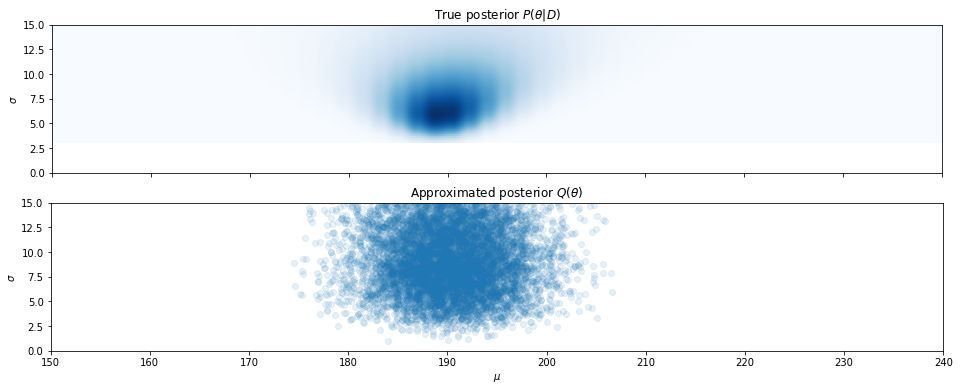

In [14]:
fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize = (16, 6))
axes[0].imshow(posterior, cmap='Blues', extent=extent, aspect=1)
axes[0].set_ylabel('$\sigma$')
axes[1].scatter(mu, sigma, alpha=0.1)
axes[1].set_ylabel('$\sigma$')
axes[0].set_title('True posterior $P(\\theta|D)$')
axes[1].set_title('Approximated posterior $Q(\\theta)$')
plt.xlabel('$\mu$')
plt.xlim(150, mm.max())
plt.ylim(0, ss.max())